In [32]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import math

from pathlib import Path
from collections import defaultdict
from sklearn.decomposition import PCA

In [12]:
image_group = 10

In [13]:
PATH_PROJECT = Path('/home/team/sasha/data/experimental/image_retrieval/')
# path_tmpl = str(PATH_PROJECT) + '/.data/imat2011/result_jpg_300/' + '%d_%d.jpg'
path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
paths = [path_tmpl % (image_group, i) for i in range(1,6)]
imgs = [cv.imread(path) for path in paths]

In [14]:
# path_labels = PATH_PROJECT / '.data/imat2011/learning.txt'
path_labels = 'learning.txt'

def get_labels(path_lables):
    
    with open(path_lables, 'r', newline='\n') as fin:
        learning = [line.strip() for line in fin]
    
    learning_dict = defaultdict(set)
    for l in learning:
        g, i = l.split('.')[0].split('_')
        learning_dict[int(g)].add(int(i))
    
    return learning_dict

In [15]:
learning_dict = get_labels(path_labels)

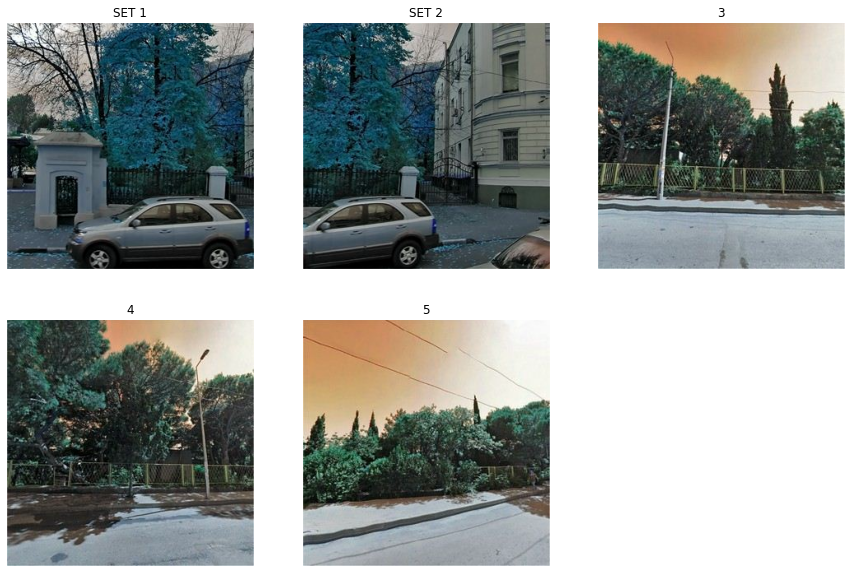

In [16]:
plt.figure(figsize=(15, 10))
for i, img in enumerate(imgs, 1):
    ax = plt.subplot(2, 3, i)
    plt.imshow(img)
    if i in learning_dict[image_group]:
        plt.title("SET %d" % i)
    else:
        plt.title("%d" % i)
    plt.axis("off")

### SIFT

In [122]:
minHessian = 400
img1, img2 = imgs[0], imgs[1]
sift = cv.xfeatures2d_SIFT.create()
kps1, dscr1 = sift.detectAndCompute(img1, None)
kps2, dscr2 = sift.detectAndCompute(img2, None)
dscr1.shape, dscr2.shape

((941, 128), (799, 128))

In [163]:
%%time
# Matching descriptor vectors with a FLANN based matcher
# Since SIFT is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(dscr1, dscr2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.5
good_matches = []
for m, n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

Wall time: 22.9 ms


In [164]:
#-- Draw matches
img_matches = np.empty(
    (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), 
    dtype=np.uint8)

_ = cv.drawMatches(
    img1, kps1,
    img2, kps2,
    good_matches,
    img_matches,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

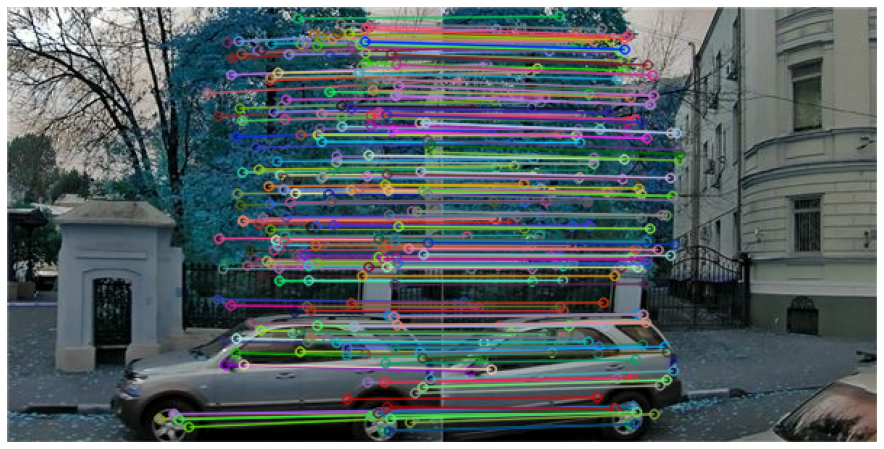

In [165]:
plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.axis('off')
plt.show()

### PCA-SIFT

In [146]:
pca = PCA(n_components=128)
pca.fit(dscr1)
pca_dscr1 = pca.singular_values_
pca.fit(dscr2)
pca_dscr2 = pca.singular_values_
pca_dscr1.shape, pca_dscr2.shape

((128,), (128,))

In [153]:
%%time
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(pca_dscr1, pca_dscr2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
pca_good_matches = []
for m, n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        pca_good_matches.append(m)

Wall time: 774 µs


### Retrieval using SIFT

In [99]:
import heapq
import glob
from scipy import spatial

In [154]:
minHessian = 400
sift = cv.xfeatures2d_SIFT.create()

In [155]:
%%time

index = []
for i, path in enumerate(list(glob.glob('result_jpg_300/[0-9][0-9]_*.jpg'))):
    try:
        img = cv.imread(str(path))
        kps, dscr = sift.detectAndCompute(img, None)
        index.append((dscr, img))
    except:
        pass

Wall time: 16.1 s


In [156]:
len(index)

450

In [166]:
# Calculate distance by KNN match
def get_closests(index, img, k=9):
    if len(index) < k:
        return index
    
    dscr, _ = img
    closests = []
    
    for i, (dscr_other, _) in enumerate(index[:k]):
        knn_matches = matcher.knnMatch(dscr, dscr_other, 2)
        ratio_thresh = 0.5
        good_matches = []
        for m, n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        closests.append((len(good_matches), i))
    
    heapq.heapify(closests)    

    for i, (dscr_other, _) in enumerate(index):
        knn_matches = matcher.knnMatch(dscr, dscr_other, 2)
        ratio_thresh = 0.7
        good_matches = []
        for m, n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)

        d = len(good_matches)
        
        if d > closests[0][0]:
            heapq.heapreplace(closests, (d, i))
    return closests

In [167]:
# Calculate distance by cosine similarity
def get_closests_cos(index, img, k=9):
    if len(index) < k:
        return index
    
    dscr, _ = img
    closests = []
    
    for i, (dscr_other, _) in enumerate(index[:k]):
        cos_sim = np.inner(dscr, dscr_other) / (np.linalg.norm(dscr) * np.linalg.norm(dscr_other))
        closests.append((cos_sim, i))
    
    heapq.heapify(closests)    

    for i, (dscr_other, _) in enumerate(index):
        cos_sim = np.inner(dscr, dscr_other) / (np.linalg.norm(dscr) * np.linalg.norm(dscr_other))

        d = cos_sim
        
        if d > closests[0][0]:
            heapq.heapreplace(closests, (d, i))
    return closests

In [168]:
%%time
closests = get_closests(index, index[100], k=9)

Wall time: 8.33 s


In [169]:
closests.sort(reverse=True)

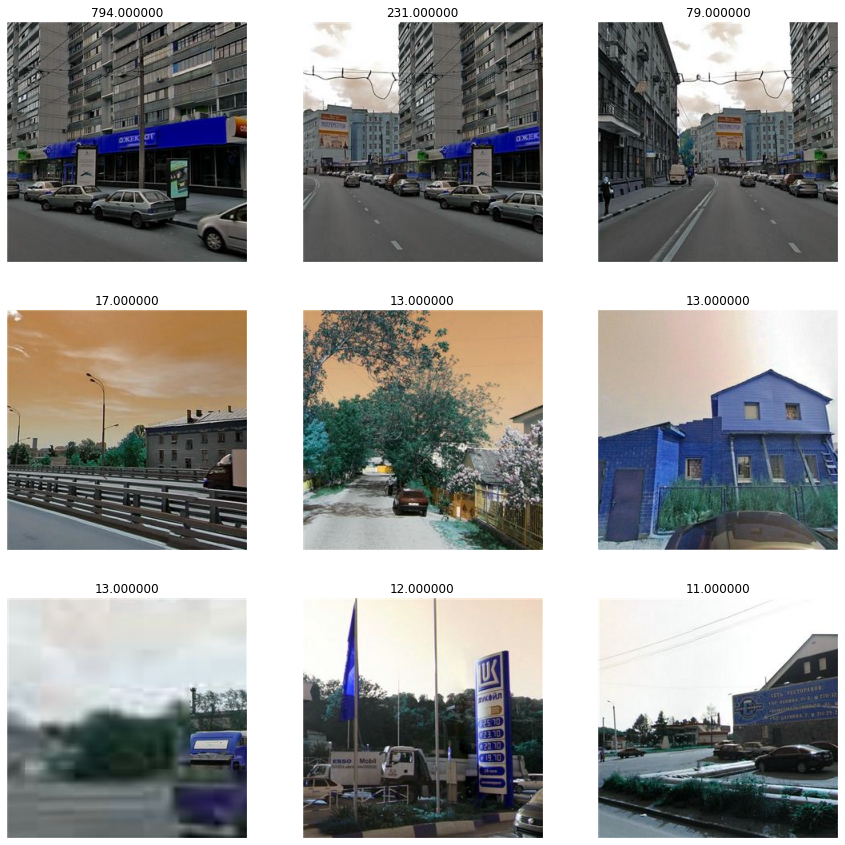

In [170]:
plt.figure(figsize=(15, 15))
for i, (d, _id) in enumerate(closests, 1):
    ax = plt.subplot(3, 3, i)
    plt.imshow(index[_id][1])
    plt.title("%f" % d)
    plt.axis("off")

### Retrieval using PCA-SIFT

In [286]:
%%time

pca_index = []
pca = PCA(n_components=127)
for i, path in enumerate(list(glob.glob('result_jpg_300/[0-9][0-9]_*.jpg'))):
    try:
        img = cv.imread(str(path))
        kps, dscr = sift.detectAndCompute(img, None)
        pca.fit(dscr)
        pca_dscr = pca.singular_values_
        pca_index.append((pca_dscr, img))
    except:
        pass

Wall time: 13.8 s


In [287]:
len(pca_index)

450

In [281]:
%%time
closests = get_closests(pca_index, pca_index[217], k=9)
# closests = get_closests_cos(pca_index, pca_index[80], k=9)

Wall time: 222 ms


In [282]:
closests.sort(reverse=True)

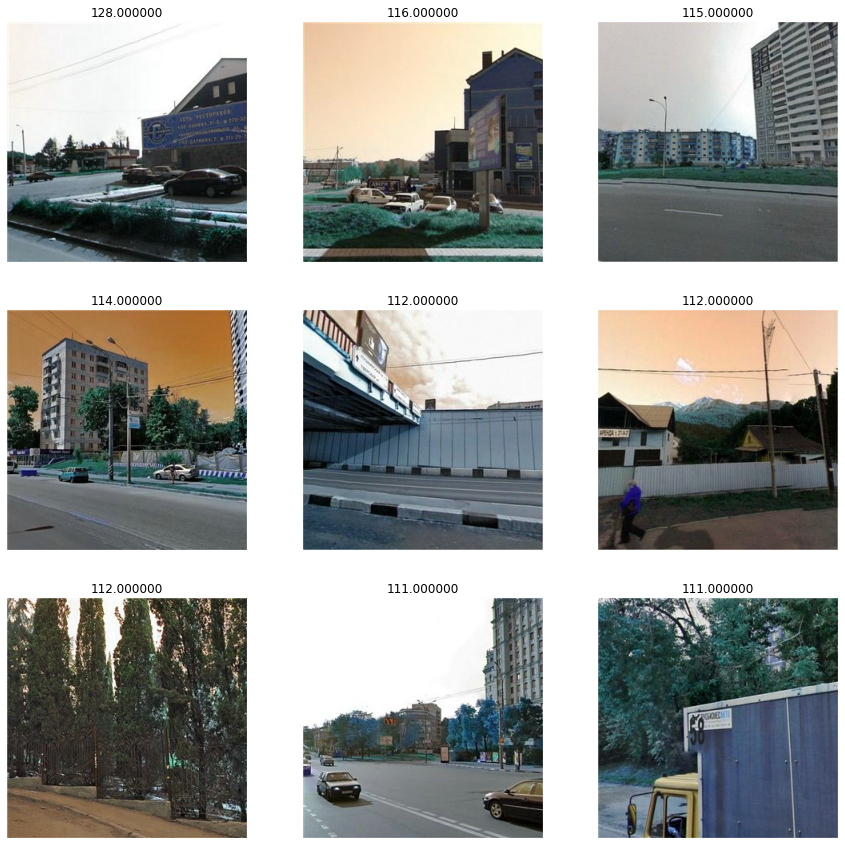

In [283]:
plt.figure(figsize=(15, 15))
for i, (d, _id) in enumerate(closests, 1):
    ax = plt.subplot(3, 3, i)
    plt.imshow(pca_index[_id][1])
    plt.title("%f" % d)
    plt.axis("off")

In [294]:
# Match by knn
from sklearn.neighbors import NearestNeighbors

pca_dscr = [index[0] for index in pca_index]
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(pca_dscr)
distances, indices = nbrs.kneighbors(pca_dscr)

In [295]:
indices, distances

(array([[  0, 213, 138, 359, 337, 349],
        [  1,  33, 347, 433, 136, 100],
        [  2, 126,  92, 395, 288, 161],
        ...,
        [447,  51, 232, 250, 422, 251],
        [448, 210, 250,  25, 422,  23],
        [449, 436, 160,  77, 102, 323]], dtype=int64),
 array([[  0.        , 327.26263984, 342.92665171, 344.55573439,
         344.64184216, 346.33077459],
        [  0.        , 253.13336965, 258.33589416, 268.17556074,
         279.93049743, 283.06692076],
        [  0.        , 293.51412322, 295.2480294 , 301.58308246,
         334.62840123, 335.57614813],
        ...,
        [  0.        , 276.00328194, 276.35685455, 291.94350971,
         308.54746146, 319.28297038],
        [  0.        , 273.27107013, 317.47147545, 333.09429679,
         349.90237542, 351.96651537],
        [  0.        , 294.40653884, 299.37048061, 301.17458957,
         343.65221294, 344.79635051]]))

(-0.5, 299.5, 299.5, -0.5)

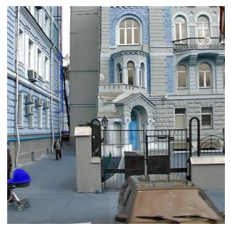

In [358]:
idx = 215
indice, distance = indices[idx], distances[idx]
plt.imshow(pca_index[idx][1])
plt.axis("off")

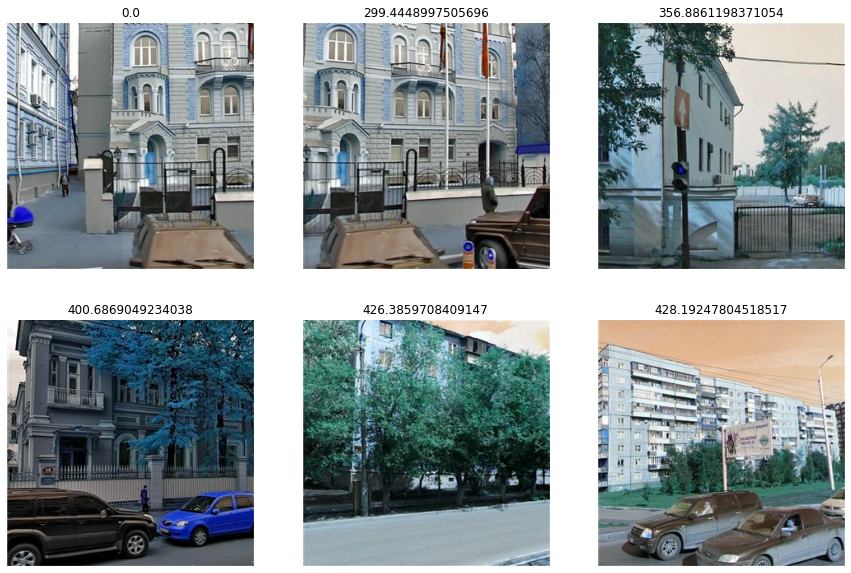

In [359]:
plt.figure(figsize=(15, 10))
for i, ind in enumerate(indice, 1):
    ax = plt.subplot(2, 3, i)
    plt.imshow(pca_index[ind][1])
    plt.title(distance[i - 1])
    plt.axis("off")